## Notebook to create raster masks from polygons
Needed for semantic segmentation of raster images. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
sys.path.append('scripts/')
import numpy as np
import matplotlib.pyplot as plt
import rasterio, rasterio.plot
import xarray as xr
import rioxarray as rxr
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import loadpaths
import land_cover_analysis as lca
import land_cover_visualisation as lcv
import land_cover_models as lcm
from torch.utils.data import TensorDataset, DataLoader

path_dict = loadpaths.loadpaths()

### Example tile:

(3, 8000, 8000) <class 'numpy.ndarray'>


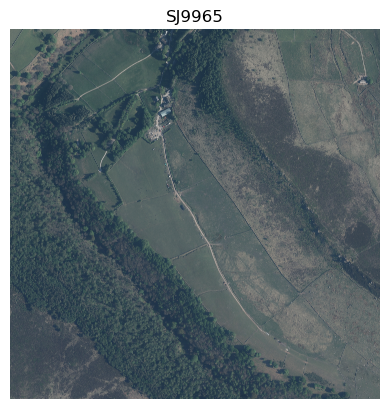

In [25]:
## Load image:

example_tiff_file = 'SJ9965.tif'
# example_tiff_file = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_2022/SE0800_lc_2022_mask.tif'
example_tiff_path = os.path.join(path_dict['image_path'], example_tiff_file)

ex_tile = lca.load_tiff(tiff_file_path=example_tiff_path, datatype='da')
lcv.plot_image_simple(im=ex_tile, name_file=example_tiff_file)

(3, 8450, 8450) <class 'numpy.ndarray'>


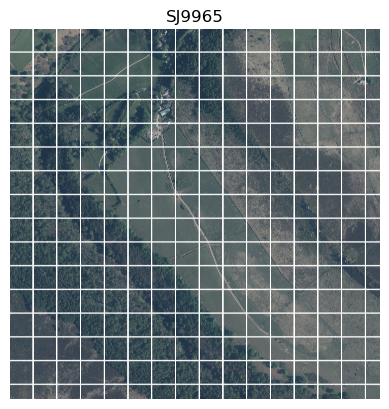

In [20]:
tmp = lcv.plot_image_as_patches(im=ex_tile, name_file=example_tiff_file)

### Automatically intersect LC polygons with tiles; and create rasterized patches:

In [7]:
## Load landcover polygons:

# df_lc_80s, mapping_class_inds = lca.load_landcover(pol_path=path_dict['lc_80s_path'])
df_lc_80s = lca.load_pols(pol_path='/home/tplas/repos/cnn-land-cover/content/evaluation_polygons/Landscape_Character_80s_2022.shp')
df_lc_80s = lca.test_validity_geometry_column(df=df_lc_80s)
df_lc_80s

Geometry Ring Self-intersection[413299.546000002 360427.712200001] for inds [37]
Attempting to make valid
Done


,AREA,PERIMETER,LC_N_80,LC_D_80,MI_PRINX,Class_Code,geometry
0,0.0,0.0,0,None,0,C,"POLYGON ((416838.937 361330.300, 416827.893 36..."
1,0.0,0.0,0,None,0,C,"POLYGON ((416930.560 361869.303, 416928.487 36..."
2,0.0,0.0,0,None,0,E,"POLYGON ((416999.997 361999.998, 416999.997 36..."
3,0.0,0.0,0,None,0,H,"POLYGON ((416331.343 361423.260, 416275.659 36..."
4,0.0,0.0,0,None,0,H,"POLYGON ((420715.375 355098.589, 420748.362 35..."
...,...,...,...,...,...,...,...
360,0.0,0.0,0,None,0,H,"POLYGON ((419000.002 371830.587, 419000.002 37..."
361,0.0,0.0,0,None,0,H,"POLYGON ((418573.799 371299.739, 418542.031 37..."
362,0.0,0.0,0,None,0,H,"POLYGON ((418683.376 371171.286, 418590.834 37..."
363,0.0,0.0,0,None,0,C,"POLYGON ((417999.999 371999.995, 418138.218 37..."


In [ ]:
# ## Get intersection of polygons with tiles
# # df_tiles = lca.create_df_with_tiff_coords(tiff_paths=lca.get_all_tifs_from_dir(path_dict['image_path']), verbose=1)  # get df of square polygons of tiles 
# df_tiles = lca.create_df_with_tiff_coords(tiff_paths=lca.get_all_tifs_from_dir('/home/tplas//data/gis/most recent APGB 12.5cm aerial/gradbach_6tiles/12.5cm Aerial Photo/117383-1_RGB_1_Shape/tiles/'), verbose=1)  # get df of square polygons of tiles 
# # df_tiles = lca.create_df_with_tiff_coords(tiff_paths=lca.get_all_tifs_from_dir(path_dict['image_path']), verbose=1)  # get df of square polygons of tiles 
# dict_intersect_pols = lca.get_pols_for_tiles(df_pols=df_lc_80s, df_tiles=df_tiles)

In [22]:
## Load shp files of tiles and intersect with PD LC:

df_tiles_sample = lca.load_pols('/home/tplas/repos/cnn-land-cover/content/evaluation_sample_50tiles/evaluation_sample_50tiles.shp')
dict_intersect_pols_tiles_sample = lca.get_pols_for_tiles(df_pols=df_lc_80s, df_tiles=df_tiles_sample, col_name='PLAN_NO',
                                                          extract_main_categories_only=True)
df_tiles_sample_lc = pd.concat(list(dict_intersect_pols_tiles_sample.values())).reset_index(drop=True)


100%|██████████| 50/50 [00:00<00:00, 228.31it/s]


In [29]:
## Convert all polygons labels to raster and save:

dict_shp = dict_intersect_pols_tiles_sample
save_mask_dir = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_2022/'
                                
for key_tile, df_tile in tqdm(dict_shp.items()):
    dict_shp[key_tile] = lca.add_main_category_index_column(df_tile)
    ex_raster = lca.convert_shp_mask_to_raster(df_shp=df_tile, filename=key_tile + '_lc_2022_mask', 
                                maskdir=save_mask_dir, 
                                col_name='class_ind',
                                # ex_tile=ex_raster,
                                # resolution=(-0.125, 0.125),
                                plot_raster=False, # whether to plot
                                save_raster=True, # whether to store on disk
                                verbose=0)
    assert ex_raster['class_ind'].shape == (8000, 8000), key_tile


100%|██████████| 50/50 [02:44<00:00,  3.28s/it]


In [28]:
key_tile

'SE0800'

### Some plots of class distributions:

Text(0.5, 1.0, 'Distribution of LC of entire PD')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


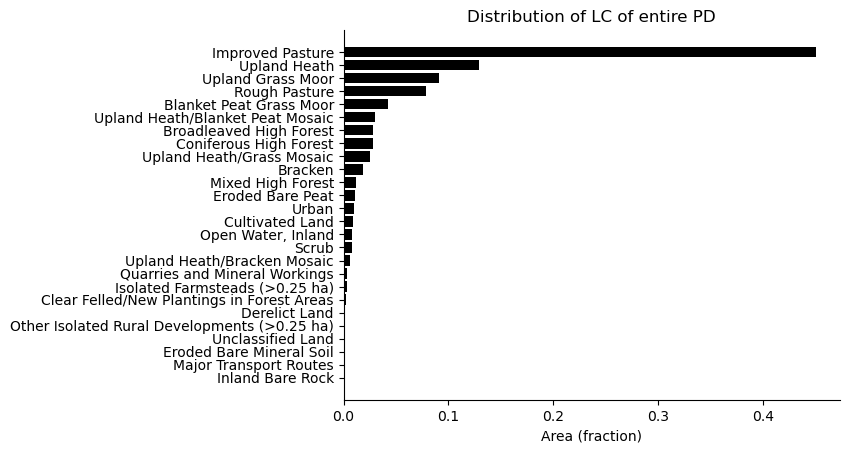

In [5]:
ax_distr, _ = lcv.plot_distr_classes_from_shape(df_lc=df_lc_80s)
ax_distr.set_title('Distribution of LC of entire PD')

Text(0.5, 1.0, 'Distribution of LC of tiles-few-changes data set')

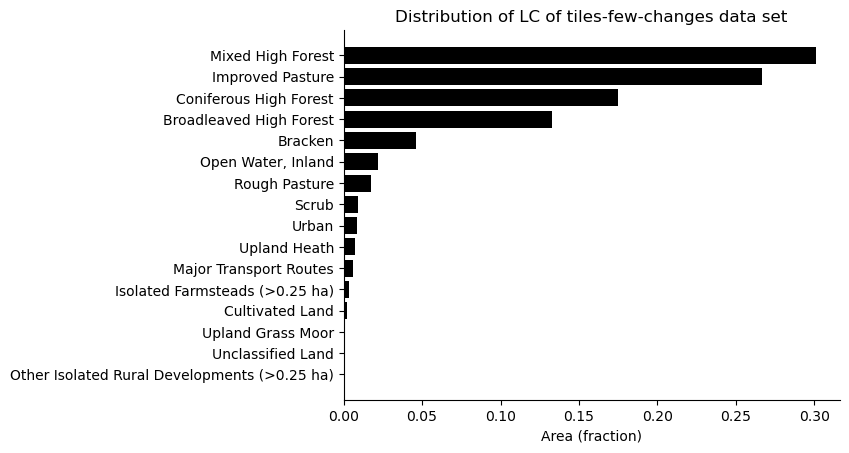

In [6]:
ax_distr, _ = lcv.plot_distr_classes_from_shape(df_lc=df_tiles_few_changes_lc)
ax_distr.set_title('Distribution of LC of tiles-few-changes data set')

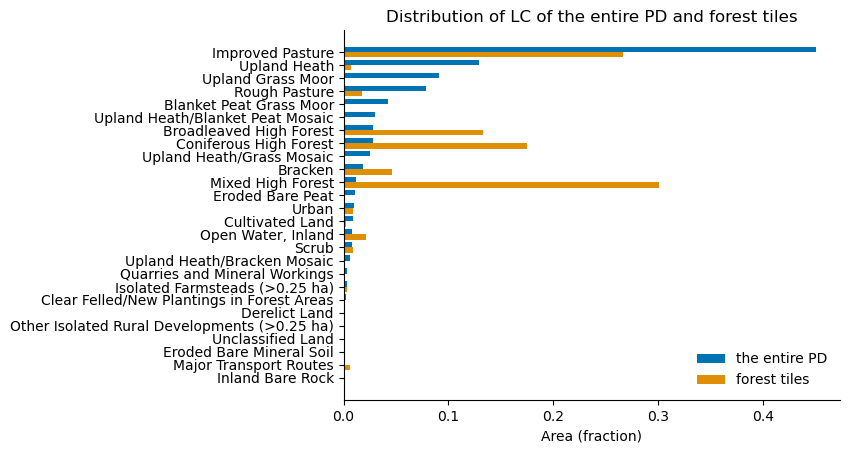

In [7]:
ax_distr, _ = lcv.plot_distr_classes_from_multiple_shapes(dict_dfs_lc={'the entire PD': df_lc_80s, 'forest tiles': df_tiles_few_changes_lc})

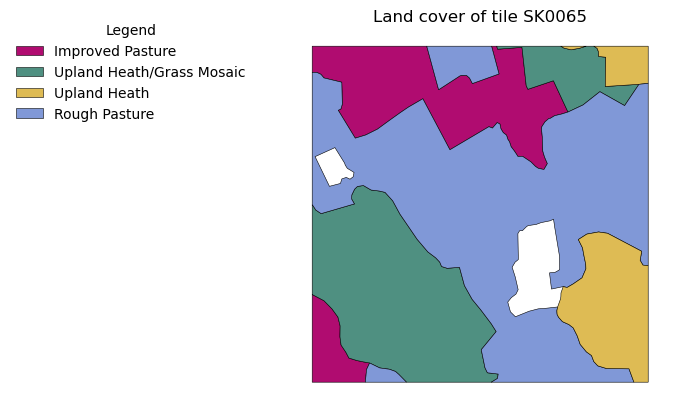

In [8]:
_ = lcv.plot_lc_from_gdf_dict(df_pols_tiles=dict_intersect_pols, tile_name="SK0065")

Current data size cube is 512.128008 MB
New cube data size is 64.128008 MB


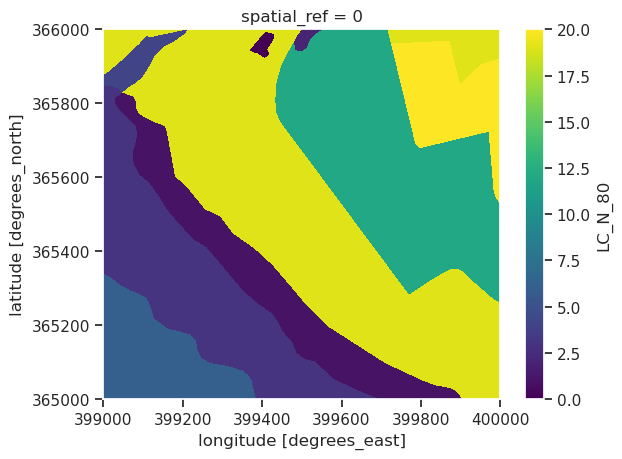

In [137]:
## Example: convert polygons labels to raster:
dict_shp = dict_intersect_pols
key_tile = "SJ9965"

ex_raster = lca.convert_shp_mask_to_raster(df_shp=dict_shp[key_tile], filename=key_tile + '_lc_80s_mask', 
                                plot_raster=True, # whether to plot
                                save_raster=False, # whether to store on disk
                                verbose=1)

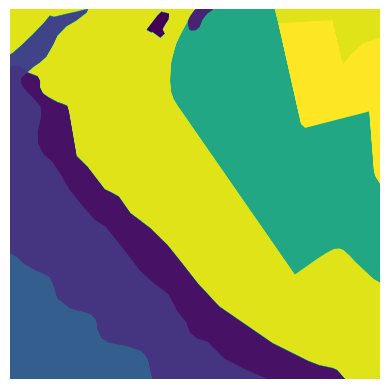

In [11]:
## Load saved raster mask
ex_mask_tif = lca.load_tiff(tiff_file_path=os.path.join(path_dict['mask_path'], 'SJ9965' + '_lc_80s_mask.tif'))
lcv.plot_image_simple(im=ex_mask_tif)

## Create Patches and save:

In [3]:
# list_tiff_files = lca.get_all_tifs_from_dir(dirpath='/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/tiles/')
list_tiff_files = lca.get_all_tifs_from_subdirs(dirpath='/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/12.5cm Aerial Photo/')
list_mask_files = lca.get_all_tifs_from_dir(dirpath='/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_2022/')
print(f'Found {len(list_tiff_files)} images and {len(list_mask_files)} masks')
print(list_tiff_files[:4])

Found 50 images and 50 masks
['/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/12.5cm Aerial Photo/117574-1_RGB_29_Shape/SK0554.tif', '/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/12.5cm Aerial Photo/117574-1_RGB_40_Shape/SK1798.tif', '/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/12.5cm Aerial Photo/117574-1_RGB_50_Shape/SK0686.tif', '/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/12.5cm Aerial Photo/117574-1_RGB_4_Shape/SK2196.tif']


In [4]:
dir_im_patches = '/home/tplas/tmp/'
dir_mask_patches = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/masks_2022/'

In [8]:
lca.create_and_save_patches_from_tiffs(list_tiff_files=list_tiff_files, list_mask_files=list_mask_files,
                                       dir_im_patches=dir_im_patches, dir_mask_patches=dir_mask_patches,
                                       mask_fn_suffix='_lc_2022_mask.tif',
                                       save_files=True)

50it [00:31,  1.58it/s]


In [ ]:
# tmp = np.load(f'/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/masks_2022/SE0800_patch{str(224).zfill(3)}_lc_2022_mask.npy', 'r') 
# plt.imshow(tmp)


In [ ]:
# dict_npys = {}
# for ii in range(225):
#     tmp_path = f'/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/masks_2022/SE0800_patch{str(ii).zfill(3)}_lc_2022_mask.npy' 
#     dict_npys[ii] = np.load(tmp_path, 'r')

# fig, ax = plt.subplots(15, 15, figsize=(20, 20), gridspec_kw={'wspace': 0, 'hspace': 0})

# icol, irow = 0, 0
# for ii, im in dict_npys.items():
#     curr_ax = ax[irow, icol]
#     tmp = curr_ax.imshow(im, interpolation='none', vmin=0 ,vmax=5)
#     lcv.naked(curr_ax)
#     icol += 1 
#     if icol == 15:
#         irow += 1
#         icol =0 
    
# plt.colorbar(tmp)

## Notebook to create train & test data sets
- Take tile tiffs, and create patches of image & LC mask
- Save patches to be loaded by a DataLoader for training/testing

## Notebook to create label mapping transformations
- Map old labels to new labels
- Old labels: 1980s classification scheme
- Multiple new label schemes possible.


In [5]:
# save_folder = '/home/tplas/repos/cnn-land-cover/content/label_mapping_dicts/'
dict_mapping = lca.create_empty_label_mapping_dict()

In [18]:
tmp = lca.create_new_label_mapping_dict(save_mapping=True, mapping_type='main_categories')